In [2]:
from util import setup_notebook
setup_notebook()
%load_ext autoreload
%autoreload 2

In [3]:
from testmining.apfd import read_tests

In [25]:
df = read_tests('../output/square@okhttp/baseline/okhttp@optimal-failure.csv')
#df = read_tests('../output/Graylog2@graylog2-server/baseline/graylog2-server@optimal-failure.csv')

In [26]:
df.head()

travisBuildNumber  travisBuildId  travisJobId  \
0                  1        2685383      2685384   
1                  1        2685383      2685384   
2                  1        2685383      2685384   
3                  1        2685383      2685384   
4                  1        2685383      2685384   

                                 testName  index  duration  count  failures  \
0  libcore.net.http.HttpResponseCacheTest      0     2.796    100         0   
1         libcore.net.http.RawHeadersTest      1     0.001      2         0   
2      libcore.net.http.URLConnectionTest      2     5.621    110         0   
3   libcore.net.http.NewURLConnectionTest      3     0.000      1         0   
4     libcore.net.spdy.SpdyConnectionTest      4     0.218     11         0   

   errors  skipped  red  
0       1        0    1  
1       0        0    0  
2       0        0    0  
3       0        0    0  
4       0        0    0

In [27]:
from functools import partial

def red_percent_budget(budget, job):
    faults = job['red'].sum()
    spent = job['duration'].cumsum()
    executed = spent < budget
    found = job[executed]['red'].sum()
    return (found / faults) * 100

def faults_detected(tests, budget):
    return tests.groupby('travisJobId').apply(partial(red_percent_budget, budget)).rename(budget)

In [28]:
import altair as alt

In [29]:
import numpy as np

def allocate_budgets(tests, fac=1.1):

    def red_duration(job):
        return job[job['red'] > 0]['duration'].sum()

    max_duration = tests.groupby('travisJobId').apply(red_duration).max()
    log = np.log(max_duration) / np.log(fac)
    return np.append(0, np.power(fac, np.arange(0, np.ceil(log) + 1)))

In [30]:
allocate_budgets(df)

array([ 0.        ,  1.        ,  1.1       ,  1.21      ,  1.331     ,
        1.4641    ,  1.61051   ,  1.771561  ,  1.9487171 ,  2.14358881,
        2.35794769,  2.59374246,  2.85311671,  3.13842838,  3.45227121,
        3.79749834,  4.17724817,  4.59497299,  5.05447028,  5.55991731,
        6.11590904,  6.72749995,  7.40024994,  8.14027494,  8.95430243,
        9.84973268, 10.83470594, 11.91817654, 13.10999419, 14.42099361,
       15.86309297, 17.44940227, 19.1943425 , 21.11377675, 23.22515442,
       25.54766986, 28.10243685, 30.91268053, 34.00394859, 37.40434344,
       41.14477779, 45.25925557, 49.78518112])

In [55]:
np.diff(allocate_budgets(df))

array([1.        , 0.1       , 0.11      , 0.121     , 0.1331    ,
       0.14641   , 0.161051  , 0.1771561 , 0.19487171, 0.21435888,
       0.23579477, 0.25937425, 0.28531167, 0.31384284, 0.34522712,
       0.37974983, 0.41772482, 0.4594973 , 0.50544703, 0.55599173,
       0.6115909 , 0.67274999, 0.74002499, 0.81402749, 0.89543024,
       0.98497327, 1.08347059, 1.19181765, 1.31099942, 1.44209936,
       1.5863093 , 1.74494023, 1.91943425, 2.11137767, 2.32251544,
       2.55476699, 2.81024368, 3.09126805, 3.40039486, 3.74043434,
       4.11447778, 4.52592556])

In [31]:
#dx = [faults_detected(df, budget) for budget in range(0, 31, 1)]
dx = [faults_detected(df, budget) for budget in allocate_budgets(df)]

In [32]:
import pandas as pd

dy = pd.concat(dx, axis=1)
dy.head()

0.000000   1.000000   1.100000   1.210000   1.331000   1.464100   \
travisJobId                                                                     
2685384            0.0        0.0        0.0        0.0        0.0        0.0   
2697352            0.0        0.0        0.0        0.0        0.0        0.0   
2820645            0.0        0.0        0.0        0.0        0.0        0.0   
2923196            0.0        0.0        0.0        0.0        0.0        0.0   
2923220            0.0        0.0        0.0        0.0        0.0        0.0   

             1.610510   1.771561   1.948717   2.143589   ...  21.113777  \
travisJobId                                              ...              
2685384            0.0        0.0        0.0        0.0  ...      100.0   
2697352            0.0        0.0        0.0        0.0  ...      100.0   
2820645            0.0        0.0        0.0        0.0  ...      100.0   
2923196            0.0        0.0        0.0        0.0  ...      100.0   
2923220            0.0        0.0        0.0        0.0  ...      100.0   

             23.225154  25.547670  28.102437  30.912681  34.003949  37.404343  \
travisJobId                                                                     
2685384          100.0      100.0      100.0      100.0      100.0      100.0   
2697352          100.0      100.0      100.0      100.0      100.0      100.0   
2820645          100.0      100.0      100.0      100.0      100.0      100.0   
2923196          100.0      100.0      100.0      100.0      100.0      100.0   
2923220          100.0      100.0      100.0      100.0      100.0      100.0   

             41.144778  45.259256  49.785181  
travisJobId                                   
2685384          100.0      100.0      100.0  
2697352          100.0      100.0      100.0  
2820645          100.0      100.0      100.0  
2923196          100.0      100.0      100.0  
2923220          100.0      100.0      100.0  

[5 rows x 43 columns]

In [33]:
dy.idxmax(axis=1).median()

8.95430243255239

In [34]:
dz = pd.melt(dy, var_name='budget', value_name='faultsDetected')
dz.head()

budget  faultsDetected
0     0.0             0.0
1     0.0             0.0
2     0.0             0.0
3     0.0             0.0
4     0.0             0.0

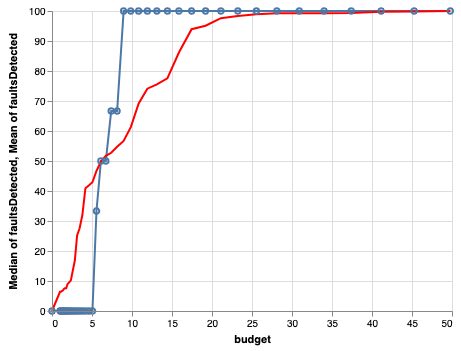

In [35]:
alt.Chart(dz).mark_line().encode(x='budget', y='median(faultsDetected)') + \
alt.Chart(dz).mark_line(color='red').encode(x='budget', y='mean(faultsDetected)') + \
alt.Chart(dz).mark_point().encode(x='budget', y='median(faultsDetected)')

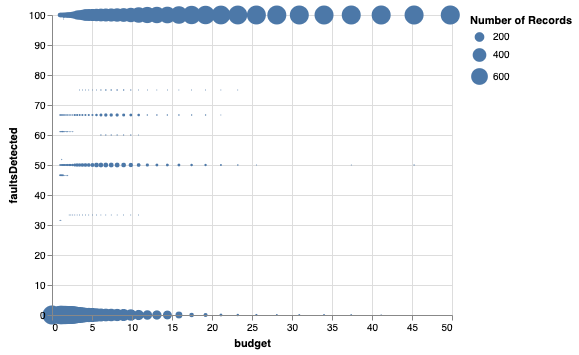

In [59]:
alt.Chart(dz).mark_point(filled=True).encode(x=alt.X('budget:Q'), y='faultsDetected', size='count()')

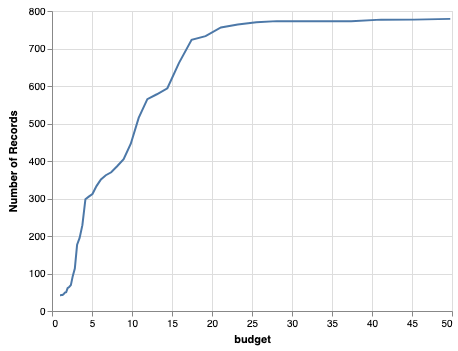

In [51]:
alt.Chart(dz).mark_line().encode(
    x=alt.X('budget'),
    y='count()').transform_filter('datum.faultsDetected == 100')